In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import os

In [3]:
D = 10
NP = 100
schwefel_bounds = (-500, 500)


def schwefel(coordinates):
    result = 0
    for coordinate in coordinates:
        result += coordinate * math.sin(math.sqrt(abs(coordinate)))
    return 418.9829 * len(coordinates) - result

In [4]:
def generate_individual(dimensions, bounds, idx):
    lower, upper = bounds
    return {"id": idx, "genes": lower + np.random.rand(dimensions) * (upper - lower)}

def generate_population(dimensions, bounds, population_size):
    return [generate_individual(dimensions, bounds, idx) for idx in range(population_size)]

In [5]:
def select_random_individual(population):
    return population[random.randrange(len(population))]

#def select_best_individual(population, fitnesses):
#    return population[fitnesses.index(min(fitnesses))]

In [ ]:
def rand1(population, fitnesses, mutation):
    selected = [np.array(select_random_individual(population)["genes"]) for _ in range(3)]
    return selected[0] + mutation * (selected[1] - selected[2])


In [ ]:
def bin_crossbreeding(parent, mutation_vec, crossbreeding_limit):
    new_genes = [
        mutation_vec[i] if random.random() < crossbreeding_limit else parent["genes"][i]
        for i in range(len(parent["genes"]))
    ]
    return {"id": parent["id"], "genes": new_genes}

In [ ]:
def fitness_individual(individual, fitness_function):
    return fitness_function(individual)

def fitness_population(population, fitness_function):
    return [fitness_individual(ind, fitness_function) for ind in population]

In [ ]:
def check_bounds(individual, bounds):
    lower, upper = bounds
    corrected_genes = np.array([
        max(lower, min(upper, 2*upper - gene if gene > upper else 2*lower - gene if gene < lower else gene))
        for gene in individual["genes"]
    ])
    return {"id": individual["id"], "genes": corrected_genes}

In [ ]:
def save_population_to_file(population, generation, filename="population_log_DE.csv"):
    df = pd.DataFrame([
        {"generation": generation, "id": ind["id"], **{f"gene_{i}": ind["genes"][i] for i in range(len(ind["genes"]))}}
        for ind in population
    ])

    df.to_csv(filename, mode="a", header=not os.path.exists(filename), index=False)

In [ ]:
def differential_evolution(generations, dimensions, population_size,
                          crossbreeding_limit, mutation, mutation_type):
    population = generate_population(dimensions, schwefel_bounds, population_size)
    fitnesses = fitness_population([ind["genes"] for ind in population], schwefel)
    fitness_history = [fitnesses]

    for gen in range(generations - 1):
        population_new = []
        fitness_new = []

        for index_individual in range(len(population)):
            mutation_vec = mutation_type(population, fitnesses, mutation)
            child = bin_crossbreeding(population[index_individual], mutation_vec, crossbreeding_limit)
            child = check_bounds(child, schwefel_bounds)

            fitness_child = fitness_individual(child["genes"], schwefel)
            if fitness_child <= fitnesses[index_individual]:
                population_new.append(child)
                fitness_new.append(fitness_child)
            else:
                population_new.append(population[index_individual])
                fitness_new.append(fitnesses[index_individual])

        population = population_new
        fitnesses = fitness_new
        fitness_history.append(fitnesses)
        save_population_to_file(population, gen)


    return fitness_history

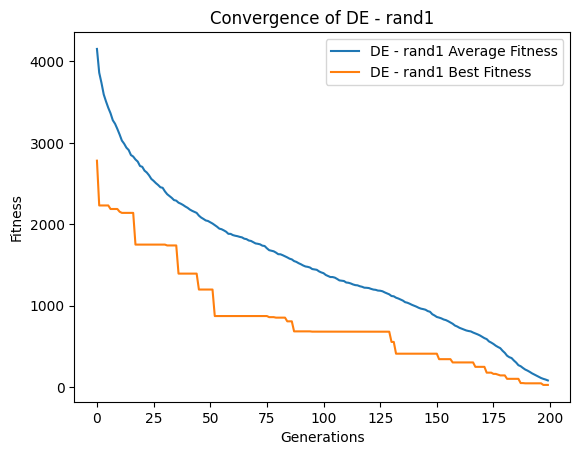

Last generation best fitness for DE - rand1: 24.833625339185346
Last generation average fitness for DE - rand1: 79.9074324775829


In [14]:
results1 = differential_evolution(200, D, NP, 0.8, 0.5, rand1)

for i, (results, label) in enumerate(zip([results1], ["DE - rand1"])):
    avg_fitness = [np.mean(gen) for gen in results]
    best_fitness = [min(gen) for gen in results]
    plt.plot(avg_fitness, label=f"{label} Average Fitness")
    plt.plot(best_fitness, label=f"{label} Best Fitness")
    plt.legend()
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.title(f"Convergence of {label}")
    plt.show()
    print(f"Last generation best fitness for {label}:", best_fitness[-1])
    print(f"Last generation average fitness for {label}:", avg_fitness[-1])